In [60]:
# Code from https://lime-ml.readthedocs.io/en/latest/lime.html, LIME for Python.
# I added comments due to the lack of documentation. I also included some changes, so I use "slic" only.
# Onr can find also interim results for perturbed_images and ridge_input_x.

In [61]:
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import cv2 as cv
from PIL import Image
import numpy as np 
import pandas as pd 
import plotly.express as px
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
from matplotlib.colors import LinearSegmentedColormap
import warnings
import time
# Explainers:
import shap
from keras.applications.resnet50 import preprocess_input
# LIME: libraries for the code from  https://lime-ml.readthedocs.io/en/latest/lime.html
from skimage import segmentation
from keras.preprocessing import image as image_keras
import copy
from functools import partial
import scipy as sp
from sklearn.linear_model import Ridge, lars_path
from sklearn.utils import check_random_state
import sklearn
from skimage.color import gray2rgb
from tqdm.auto import tqdm
import types
from lime.utils.generic_utils import has_arg

In [62]:
########################################################################################################################################################################
# Common part
########################################################################################################################################################################

In [63]:
model = load_model('model.mdl_wts.hdf5')
height = 50
width = 50
my_information = {
                0: '20km', 1: '30km', 
                2: '50km', 3: '60km', 
                4: '70km', 5: '80km',
                6: '80km_crossed', 7: '100km',
                8: '120km', 9: 'no_overtaking', 
                10: 'no_overtaking_for_tracks', 11: 'crossroads',
                12: 'priority_roads', 13: 'give_way', 
                14: 'stop', 15: 'road_closed', 
                16: 'no_tractor', 17: 'no_entry',
                18: 'attention', 19: 'sharp_curve_left', 
                20: 'sharp_curve_right', 21: 'zigzag_left',
                22: 'rough_road', 23: 'car_skid',
                24: 'road_narrowing_right', 25: 'road_works', 
                26: 'traffic_light', 27: 'crosswalk', 
                28: 'children_crossing', 29: 'bike_road',
                30: 'snow', 31: 'wild_animal', 
                32: 'derestriction', 33: 'mandatory_right_turn', 
                34: 'mandatory_left_turn', 35: 'mandatory_straight_ahead',
                36: 'mandatory_straight_ahead_or_turning_right', 37: 'mandatory_straight_ahead_or_turning_left', 
                38: 'mandatory_passing_right', 39: 'mandatory_passing_left', 
                40: 'mandatory_direction_of_the_roundabout', 41: 'derestriction_of_overtaking', 
                42: 'derestriction_of_overtaking_for_tracks'}

In [64]:
data=[]
image=cv.imread('.../Test/00001.png')
imageRGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)
img = Image.fromarray(imageRGB)
image_from_array = img
size_image = image_from_array.resize((height, width))
data.append(np.array(size_image))
X_test=np.array(data)
X_test = X_test.astype('float32')/255 
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
X_test.shape

1/1 [==============================] - 0s 33ms/step


(1, 50, 50, 3)

1/1 [==============================] - 0s 11ms/step
[4.690099859393556e-34, 1.0, 1.2637946652696158e-31, 0.0, 1.3149640004824672e-34, 9.64073198505937e-26, 1.0136422482191054e-37, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


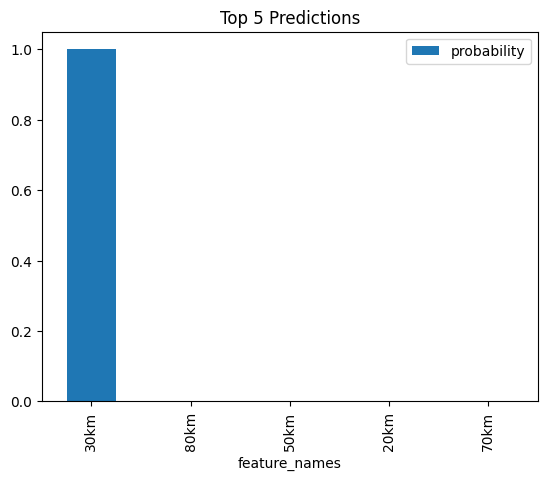

In [65]:
# predict the class
result = model.predict(X_test)
feature_names = my_information.values()
top_preds = np.argsort(-result)
inds = top_preds[0]
#feature_names = [feature_names[i] for i in inds]
result = result.tolist()
top_5_pred = pd.DataFrame(
	{'feature_names': feature_names,
	'probability': result[0]
	})
top_5_pred = top_5_pred.sort_values(by='probability', ascending=False)[0:5]
top_5_pred.plot(x="feature_names", y='probability', kind='bar', title='Top 5 Predictions')
print(result[0])

In [66]:
fig = px.bar(top_5_pred, x="feature_names", y="probability",
                 width=1000, height=1000)
fig.update_layout(
    font=dict(size=25),
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [67]:
top_5_pred

,feature_names,probability
1,30km,1.000000e+00
5,80km,9.640732e-26
2,50km,1.263795e-31
0,20km,4.690100e-34
4,70km,1.314964e-34


In [68]:
########################################################################################################################################################################

In [69]:
#LIME

In [70]:
global perturbed_images
perturbed_images = []
global ridge_input_x
ridge_input_x = []

In [71]:
"""
Contains abstract functionality for learning locally linear sparse model.
"""


class LimeBase(object):
    """Class for learning a locally linear sparse model from perturbed data"""
    def __init__(self,
                 kernel_fn,
                 verbose=False,
                 random_state=None):
        """Init function

        Args:
            kernel_fn: function that transforms an array of distances into an
                        array of proximity values (floats).
            verbose: if true, print local prediction values from linear model.
            random_state: an integer or numpy.RandomState that will be used to
                generate random numbers. If None, the random state will be
                initialized using the internal numpy seed.
        """
        self.kernel_fn = kernel_fn
        self.verbose = verbose
        self.random_state = check_random_state(random_state)

    @staticmethod
    def generate_lars_path(weighted_data, weighted_labels):
        """Generates the lars path for weighted data.

        Args:
            weighted_data: data that has been weighted by kernel
            weighted_label: labels, weighted by kernel

        Returns:
            (alphas, coefs), both are arrays corresponding to the
            regularization parameter and coefficients, respectively
        """
        x_vector = weighted_data
        alphas, _, coefs = lars_path(x_vector,
                                     weighted_labels,
                                     method='lasso',
                                     verbose=False)
        return alphas, coefs

    def forward_selection(self, data, labels, weights, num_features):
        """Iteratively adds features to the model"""
        clf = Ridge(alpha=0, fit_intercept=True, random_state=self.random_state)
        used_features = []
        for _ in range(min(num_features, data.shape[1])):
            max_ = -100000000
            best = 0
            for feature in range(data.shape[1]):
                if feature in used_features:
                    continue
                clf.fit(data[:, used_features + [feature]], labels,
                        sample_weight=weights)
                score = clf.score(data[:, used_features + [feature]],
                                  labels,
                                  sample_weight=weights)
                if score > max_:
                    best = feature
                    max_ = score
            used_features.append(best)
        return np.array(used_features)

    def feature_selection(self, data, labels, weights, num_features, method):
        """Selects features for the model. see explain_instance_with_data to
           understand the parameters."""
        if method == 'none':
            return np.array(range(data.shape[1]))
        elif method == 'forward_selection':
            return self.forward_selection(data, labels, weights, num_features)
        elif method == 'highest_weights':
            clf = Ridge(alpha=0.01, fit_intercept=True,
                        random_state=self.random_state)
            clf.fit(data, labels, sample_weight=weights)

            coef = clf.coef_
            if sp.sparse.issparse(data):
                coef = sp.sparse.csr_matrix(clf.coef_)
                weighted_data = coef.multiply(data[0])
                # Note: most efficient to slice the data before reversing
                sdata = len(weighted_data.data)
                argsort_data = np.abs(weighted_data.data).argsort()
                # Edge case where data is more sparse than requested number of feature importances
                # In that case, we just pad with zero-valued features
                if sdata < num_features:
                    nnz_indexes = argsort_data[::-1]
                    indices = weighted_data.indices[nnz_indexes]
                    num_to_pad = num_features - sdata
                    indices = np.concatenate((indices, np.zeros(num_to_pad, dtype=indices.dtype)))
                    indices_set = set(indices)
                    pad_counter = 0
                    for i in range(data.shape[1]):
                        if i not in indices_set:
                            indices[pad_counter + sdata] = i
                            pad_counter += 1
                            if pad_counter >= num_to_pad:
                                break
                else:
                    nnz_indexes = argsort_data[sdata - num_features:sdata][::-1]
                    indices = weighted_data.indices[nnz_indexes]
                return indices
            else:
                weighted_data = coef * data[0]
                feature_weights = sorted(
                    zip(range(data.shape[1]), weighted_data),
                    key=lambda x: np.abs(x[1]),
                    reverse=True)
                return np.array([x[0] for x in feature_weights[:num_features]])
        elif method == 'lasso_path':
            weighted_data = ((data - np.average(data, axis=0, weights=weights))
                             * np.sqrt(weights[:, np.newaxis]))
            weighted_labels = ((labels - np.average(labels, weights=weights))
                               * np.sqrt(weights))
            nonzero = range(weighted_data.shape[1])
            _, coefs = self.generate_lars_path(weighted_data,
                                               weighted_labels)
            for i in range(len(coefs.T) - 1, 0, -1):
                nonzero = coefs.T[i].nonzero()[0]
                if len(nonzero) <= num_features:
                    break
            used_features = nonzero
            return used_features
        elif method == 'auto':
            if num_features <= 6:
                n_method = 'forward_selection'
            else:
                n_method = 'highest_weights'
            return self.feature_selection(data, labels, weights,
                                          num_features, n_method)

    def explain_instance_with_data(self,
                                   neighborhood_data,
                                   neighborhood_labels,
                                   distances,
                                   label,
                                   num_features,
                                   feature_selection='auto',
                                   model_regressor=None):
        """Takes perturbed data, labels and distances, returns explanation.

        Args:
            neighborhood_data: perturbed data, 2d array. first element is
                               assumed to be the original data point.
            neighborhood_labels: corresponding perturbed labels. should have as
                                 many columns as the number of possible labels.
            distances: distances to original data point.
            label: label for which we want an explanation
            num_features: maximum number of features in explanation
            feature_selection: how to select num_features. options are:
                'forward_selection': iteratively add features to the model.
                    This is costly when num_features is high
                'highest_weights': selects the features that have the highest
                    product of absolute weight * original data point when
                    learning with all the features
                'lasso_path': chooses features based on the lasso
                    regularization path
                'none': uses all features, ignores num_features
                'auto': uses forward_selection if num_features <= 6, and
                    'highest_weights' otherwise.
            model_regressor: sklearn regressor to use in explanation.
                Defaults to Ridge regression if None. Must have
                model_regressor.coef_ and 'sample_weight' as a parameter
                to model_regressor.fit()

        Returns:
            (intercept, exp, score, local_pred):
            intercept is a float.
            exp is a sorted list of tuples, where each tuple (x,y) corresponds
            to the feature id (x) and the local weight (y). The list is sorted
            by decreasing absolute value of y.
            score is the R^2 value of the returned explanation
            local_pred is the prediction of the explanation model on the original instance
        """
        weights = self.kernel_fn(distances)
        labels_column = neighborhood_labels[:, label]
        used_features = self.feature_selection(neighborhood_data,
                                               labels_column,
                                               weights,
                                               num_features,
                                               feature_selection)
        if model_regressor is None:
            model_regressor = Ridge(alpha=1, fit_intercept=True,
                                    random_state=self.random_state)
        easy_model = model_regressor
        easy_model.fit(neighborhood_data[:, used_features],
                       labels_column, sample_weight=weights)
        prediction_score = easy_model.score(
            neighborhood_data[:, used_features],
            labels_column, sample_weight=weights)

        local_pred = easy_model.predict(neighborhood_data[0, used_features].reshape(1, -1))

        if self.verbose:
            print('Intercept', easy_model.intercept_)
            print('Prediction_local', local_pred,)
            print('Right:', neighborhood_labels[0, label])
        print("Sectors used: ", used_features)
        print("Used sector: ", used_features[0])
        print("Coefficient from Ridge or other regression for this sector: ", easy_model.coef_[0])
        return (easy_model.intercept_,
                sorted(zip(used_features, easy_model.coef_),
                       key=lambda x: np.abs(x[1]), reverse=True), # local_exp
                prediction_score, local_pred)

In [72]:
class BaseWrapper(object):
    """Base class for LIME Scikit-Image wrapper


    Args:
        target_fn: callable function or class instance
        target_params: dict, parameters to pass to the target_fn


    'target_params' takes parameters required to instanciate the
        desired Scikit-Image class/model
    """

    def __init__(self, target_fn=None, **target_params):
        self.target_fn = target_fn
        self.target_params = target_params

    def _check_params(self, parameters):
        """Checks for mistakes in 'parameters'

        Args :
            parameters: dict, parameters to be checked

        Raises :
            ValueError: if any parameter is not a valid argument for the target function
                or the target function is not defined
            TypeError: if argument parameters is not iterable
         """
        a_valid_fn = []
        if self.target_fn is None:
            if callable(self):
                a_valid_fn.append(self.__call__)
            else:
                raise TypeError('invalid argument: tested object is not callable,\
                 please provide a valid target_fn')
        elif isinstance(self.target_fn, types.FunctionType) \
                or isinstance(self.target_fn, types.MethodType):
            a_valid_fn.append(self.target_fn)
        else:
            a_valid_fn.append(self.target_fn.__call__)

        if not isinstance(parameters, str):
            for p in parameters:
                for fn in a_valid_fn:
                    if has_arg(fn, p):
                        pass
                    else:
                        raise ValueError('{} is not a valid parameter'.format(p))
        else:
            raise TypeError('invalid argument: list or dictionnary expected')

    def set_params(self, **params):
        """Sets the parameters of this estimator.
        Args:
            **params: Dictionary of parameter names mapped to their values.

        Raises :
            ValueError: if any parameter is not a valid argument
                for the target function
        """
        self._check_params(params)
        self.target_params = params

    def filter_params(self, fn, override=None):
        """Filters `target_params` and return those in `fn`'s arguments.
        Args:
            fn : arbitrary function
            override: dict, values to override target_params
        Returns:
            result : dict, dictionary containing variables
            in both target_params and fn's arguments.
        """
        override = override or {}
        result = {}
        for name, value in self.target_params.items():
            if has_arg(fn, name):
                result.update({name: value})
        result.update(override)
        return result


class SegmentationAlgorithm(BaseWrapper):
    """ Define the image segmentation function based on Scikit-Image
            implementation and a set of provided parameters

        Args:
            algo_type: string, segmentation algorithm among the following:
                'quickshift', 'slic', 'felzenszwalb'
            target_params: dict, algorithm parameters (valid model paramters
                as define in Scikit-Image documentation)
    """

    def __init__(self, algo_type, **target_params):
        self.algo_type = algo_type # we don't use these algorithms (quickshift, felzenszwalb)
        # if (self.algo_type == 'quickshift'):
        #     BaseWrapper.__init__(self, quickshift, **target_params)
        #     kwargs = self.filter_params(quickshift)
        #     self.set_params(**kwargs)
        # elif (self.algo_type == 'felzenszwalb'):
        #     BaseWrapper.__init__(self, felzenszwalb, **target_params)
        #     kwargs = self.filter_params(felzenszwalb)
        #     self.set_params(**kwargs)
        # elif (self.algo_type == 'slic'):
        BaseWrapper.__init__(self, slic, **target_params) # we use slic
        kwargs = self.filter_params(slic)
        self.set_params(**kwargs)

    def __call__(self, *args):
        return self.target_fn(args[0], **self.target_params)

In [73]:
class ImageExplanation(object):
    def __init__(self, image, segments):
        """Init function.

        Args:
            image: 3d numpy array
            segments: 2d numpy array, with the output from skimage.segmentation
        """
        self.image = image
        self.segments = segments
        self.intercept = {}
        self.local_exp = {}
        self.local_pred = {}
        self.score = {}

    def get_image_and_mask(self, label, positive_only=True, negative_only=False, hide_rest=False,
                           num_features=5, min_weight=0.):
        """Init function.

        Args:
            label: label to explain
            positive_only: if True, only take superpixels that positively contribute to
                the prediction of the label.
            negative_only: if True, only take superpixels that negatively contribute to
                the prediction of the label. If false, and so is positive_only, then both
                negativey and positively contributions will be taken.
                Both can't be True at the same time
            hide_rest: if True, make the non-explanation part of the return
                image gray
            num_features: number of superpixels to include in explanation
            min_weight: minimum weight of the superpixels to include in explanation

        Returns:
            (image, mask), where image is a 3d numpy array and mask is a 2d
            numpy array that can be used with
            skimage.segmentation.mark_boundaries
        """
        if label not in self.local_exp:
            raise KeyError('Label not in explanation')
        if positive_only & negative_only:
            raise ValueError("Positive_only and negative_only cannot be true at the same time.")
        segments = self.segments
        image = self.image
        exp = self.local_exp[label]
        mask = np.zeros(segments.shape, segments.dtype)
        if hide_rest:
            temp = np.zeros(self.image.shape)
        else:
            temp = self.image.copy()
        if positive_only:
            fs = [x[0] for x in exp
                  if x[1] > 0 and x[1] > min_weight][:num_features]
        if negative_only:
            fs = [x[0] for x in exp
                  if x[1] < 0 and abs(x[1]) > min_weight][:num_features]
            
        if positive_only or negative_only:
            for f in fs:
                temp[segments == f] = image[segments == f].copy()
                mask[segments == f] = 1
            return temp, mask
        else:
            mask1 = mask.copy()
            for f, w in exp[:num_features]:
                if np.abs(w) < min_weight:
                    continue
                c = 0 if w < 0 else 1
                mask[segments == f] = -1 if w < 0 else 1
                temp[segments == f] = image[segments == f].copy()
                temp[segments == f, c] = np.max(image)

            return temp, mask


class LimeImageExplainer(object):
    """Explains predictions on Image (i.e. matrix) data.
    For numerical features, perturb them by sampling from a Normal(0,1) and
    doing the inverse operation of mean-centering and scaling, according to the
    means and stds in the training data. For categorical features, perturb by
    sampling according to the training distribution, and making a binary
    feature that is 1 when the value is the same as the instance being
    explained."""

    def __init__(self, kernel_width=.25, kernel=None, verbose=False,
                 feature_selection='auto', random_state=None):
        """Init function.

        Args:
            kernel_width: kernel width for the exponential kernel.
            If None, defaults to sqrt(number of columns) * 0.75.
            kernel: similarity kernel that takes euclidean distances and kernel
                width as input and outputs weights in (0,1). If None, defaults to
                an exponential kernel.
            verbose: if true, print local prediction values from linear model
            feature_selection: feature selection method. can be
                'forward_selection', 'lasso_path', 'none' or 'auto'.
                See function 'explain_instance_with_data' in lime_base.py for
                details on what each of the options does.
            random_state: an integer or numpy.RandomState that will be used to
                generate random numbers. If None, the random state will be
                initialized using the internal numpy seed.
        """
        kernel_width = float(kernel_width)

        if kernel is None:
            def kernel(d, kernel_width):
                return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

        kernel_fn = partial(kernel, kernel_width=kernel_width)

        self.random_state = check_random_state(random_state)
        self.feature_selection = feature_selection
        self.base = LimeBase(kernel_fn, verbose, random_state=self.random_state)

    def explain_instance(self, image, classifier_fn, labels=(1,),
                         hide_color=None,
                         top_labels=5, num_features=100000, num_samples=1000,
                         batch_size=10,
                         segmentation_fn=None,
                         distance_metric='cosine',
                         model_regressor=None,
                         random_seed=None,
                         progress_bar=True):
        """Generates explanations for a prediction.

        First, we generate neighborhood data by randomly perturbing features
        from the instance (see __data_inverse). We then learn locally weighted
        linear models on this neighborhood data to explain each of the classes
        in an interpretable way (see lime_base.py).

        Args:
            image: 3 dimension RGB image. If this is only two dimensional,
                we will assume it's a grayscale image and call gray2rgb.
            classifier_fn: classifier prediction probability function, which
                takes a numpy array and outputs prediction probabilities.  For
                ScikitClassifiers , this is classifier.predict_proba.
            labels: iterable with labels to be explained.
            hide_color: If not None, will hide superpixels with this color.
                Otherwise, use the mean pixel color of the image.
            top_labels: if not None, ignore labels and produce explanations for
                the K labels with highest prediction probabilities, where K is
                this parameter.
            num_features: maximum number of features present in explanation
            num_samples: size of the neighborhood to learn the linear model
            batch_size: batch size for model predictions
            distance_metric: the distance metric to use for weights.
            model_regressor: sklearn regressor to use in explanation. Defaults
            to Ridge regression in LimeBase. Must have model_regressor.coef_
            and 'sample_weight' as a parameter to model_regressor.fit()
            segmentation_fn: SegmentationAlgorithm, wrapped skimage
            segmentation function
            random_seed: integer used as random seed for the segmentation
                algorithm. If None, a random integer, between 0 and 1000,
                will be generated using the internal random number generator.
            progress_bar: if True, show tqdm progress bar.

        Returns:
            An ImageExplanation object (see lime_image.py) with the corresponding
            explanations.
        """
        if len(image.shape) == 2:
            image = gray2rgb(image)
        if random_seed is None:
            random_seed = self.random_state.randint(0, high=1000)

        if segmentation_fn is None:
            segmentation_fn = SegmentationAlgorithm("slic", n_segments=30, compactness=15, sigma=1)

        segments = segmentation_fn(image) # now we detect segments from the initial image

        fudged_image = image.copy() 
        if hide_color is None: # if nothing is specified in explain_instance, then we keep the superpixels
            for x in np.unique(segments):
                fudged_image[segments == x] = (
                    np.mean(image[segments == x][:, 0]),
                    np.mean(image[segments == x][:, 1]),
                    np.mean(image[segments == x][:, 2])) 
        else:
            fudged_image[:] = hide_color # fill with some color (0 - DARK, 1 - LIGHT)
        top = labels

        data, labels = self.data_labels(image, fudged_image, segments,
                                        classifier_fn, num_samples,
                                        batch_size=batch_size,
                                        progress_bar=progress_bar) # here we create similar images and predict theirs classes using the CNN model
        # we assess how different the original picture is from similar ones
        distances = sklearn.metrics.pairwise_distances(
            data,
            data[0].reshape(1, -1),
            metric=distance_metric
        ).ravel()

        print("Raw distinces: ", sklearn.metrics.pairwise_distances(
            data,
            data[0].reshape(1, -1),
            metric=distance_metric
        ))
        print("Ravel: ", distances)

        ret_exp = ImageExplanation(image, segments)

        if top_labels:
            top = np.argsort(labels[0])[-top_labels:]
            ret_exp.top_labels = list(top)
            ret_exp.top_labels.reverse()
        # we iterate over classes: we use our model (for example, ridge regression) to predict a specific class.
        for label in top:
            ridge_input_x.append(data)
            (ret_exp.intercept[label],
             ret_exp.local_exp[label],
             ret_exp.score[label],
             ret_exp.local_pred[label]) = self.base.explain_instance_with_data(
                data, labels, distances, label, num_features,
                model_regressor=model_regressor,
                feature_selection=self.feature_selection)
        # for each class it returns:  
        return ret_exp

    def data_labels(self,
                    image,
                    fudged_image,
                    segments,
                    classifier_fn,
                    num_samples,
                    batch_size=10,
                    progress_bar=True):
        """Generates images and predictions in the neighborhood of this image.

        Args:
            image: 3d numpy array, the image
            fudged_image: 3d numpy array, image to replace original image when
                superpixel is turned off
            segments: segmentation of the image
            classifier_fn: function that takes a list of images and returns a
                matrix of prediction probabilities
            num_samples: size of the neighborhood to learn the linear model
            batch_size: classifier_fn will be called on batches of this size.
            progress_bar: if True, show tqdm progress bar.

        Returns:
            A tuple (data, labels), where:
                data: dense num_samples * num_superpixels
                labels: prediction probabilities matrix
        """
        n_features = np.unique(segments).shape[0]
        data = self.random_state.randint(0, 2, num_samples * n_features)\
            .reshape((num_samples, n_features)) # perturbated data
        
        labels = []
        data[0, :] = 1 
        imgs = []
        rows = tqdm(data) if progress_bar else data
        for row in rows:
            temp = copy.deepcopy(image)
            plt.imshow(temp)
            zeros = np.where(row == 0)[0]
            mask = np.zeros(segments.shape).astype(bool)
            for z in zeros:
                mask[segments == z] = True
            temp[mask] = fudged_image[mask]
            imgs.append(temp)
            perturbed_images.append(temp)
            if len(imgs) == batch_size:
                preds = classifier_fn(np.array(imgs))
                labels.extend(preds)
                imgs = []
        if len(imgs) > 0:
            preds = classifier_fn(np.array(imgs))
            labels.extend(preds)
        return data, np.array(labels)

In [74]:
file = "...Test/00001.png"
img = image_keras.load_img(file, target_size=(50, 50))
img_orig = image_keras.img_to_array(img) / 255

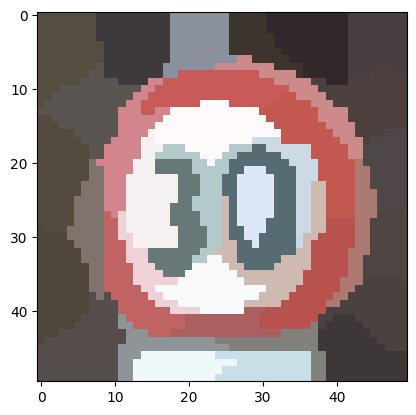

In [75]:
img=img_orig
segmentation_fn = SegmentationAlgorithm("slic", n_segments=30, compactness=15, sigma=1)
label=segmentation_fn(img)

def mean_image(image,label):
    im_rp=image.reshape((image.shape[0]*image.shape[1],image.shape[2]))
    sli_1d=np.reshape(label,-1)    
    uni=np.unique(sli_1d)
    uu=np.zeros(im_rp.shape)
    for i in uni:
        loc=np.where(sli_1d==i)[0]
        mm=np.mean(im_rp[loc,:],axis=0)
        uu[loc,:]=mm
    oo=np.reshape(uu,[image.shape[0],image.shape[1],image.shape[2]])
    return oo
    cv.imshow('img',oo)
output=mean_image(img,label) # displays the output image.
plt.imshow(output)

In [76]:
ImageExplanation(file, img_orig)

In [77]:
explainer = LimeImageExplainer()

In [78]:
mymodel = load_model('model.hdf5')

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step
Raw distinces:  [[0.        ]
 [0.23911409]
 [0.3117528 ]
 [0.3117528 ]
 [0.27452375]
 [0.23911409]
 [0.3117528 ]
 [0.20528059]
 [0.37171914]
 [0.25660806]
 [0.35111432]
 [0.29289322]
 [0.27452375]
 [0.33114395]
 [0.25660806]
 [0.43804851]
 [0.35111432]
 [0.22201339]
 [0.29289322]
 [0.27452375]
 [0.29289322]
 [0.37171914]
 [0.27452375]
 [0.35111432]
 [0.27452375]
 [0.41510235]
 [0.22201339]
 [0.37171914]
 [0.37171914]
 [0.22201339]
 [0.35111432]
 [0.3117528 ]
 [0.33114395]
 [0.37171914]
 [0.27452375]
 [0.33114395]
 [0.27452375]
 [0.25660806]
 [0.3117528 ]
 [0.3117528 ]
 [0.37171914]
 [0.35111432]
 [0.3117528 ]
 [0.3117528 ]
 [0.27452375]
 [0.37171914]
 [0.27452375]
 [0.33114395]
 [0.29289322]
 [0.23911409]
 [0.23911409]
 [0.29289322]
 [0.18889289]
 [0.3117528 ]
 [0.3117528 ]
 [0.23911409]
 [0.27452375]
 [0.18889289]
 [0.15707277]
 [0.33114395]
 [0.25660806]
 [0.41510235]
 [0.35111432]
 [0.18889289]
 [0.33114395]
 [0.39302302]
 [0.3117

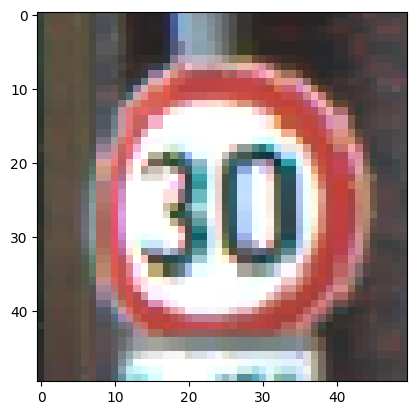

In [79]:
#Select the 16th observation for the cheque of the LIME
time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(img_orig, mymodel.predict, top_labels=40, hide_color=0, num_samples=100)

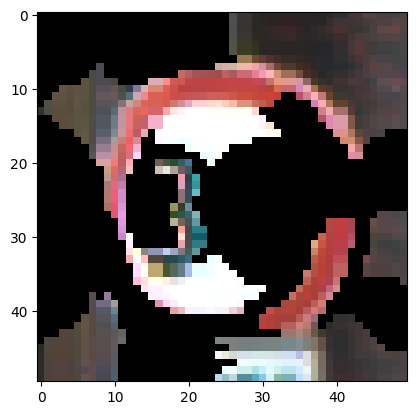

In [22]:
plt.imshow(perturbed_images[1])


In [80]:
explanation.intercept

{25: 0.0032413548888533673,
 26: 0.000308732742089215,
 27: 5.789143976984102e-06,
 28: 0.001109472289427098,
 29: 0.010861003205744372,
 30: 1.2774882316267079e-05,
 22: 0.001999135508909629,
 31: 0.003975125820535998,
 33: 2.1316996056383502e-05,
 34: -1.7349933469188068e-08,
 35: -0.0001370933089363697,
 36: 0.011858966574574213,
 37: 5.025735843599391e-06,
 38: 0.014698040160393847,
 39: 0.0010588945441198964,
 40: -0.000320466643777981,
 32: -0.015842224064497923,
 41: -0.00040456861117467793,
 42: 0.0009816043729727016,
 19: -0.0013798739728156414,
 3: 0.09594396580001688,
 7: 0.1043141359619176,
 8: 0.01716370520199984,
 20: 0.02465611362160479,
 10: 0.06099437357232026,
 11: 9.640338622939778e-05,
 9: 6.0388270877144776e-05,
 13: 0.1211760948302367,
 14: 0.004015842239521104,
 15: 0.05816643548736938,
 16: 0.0005612340086296576,
 17: 0.0008870026243274991,
 18: 0.003760776905897368,
 12: 0.016964542235655484,
 6: 0.004976254429427132,
 0: 0.0002425913338517236,
 4: 0.0971220316

In [81]:
explanation.score

{25: 0.35079305109706294,
 26: 0.45743218740703184,
 27: 0.3834568762772108,
 28: 0.3581193719101703,
 29: 0.37532157142002165,
 30: 0.3474729570981294,
 22: 0.409281582335982,
 31: 0.4272143474018284,
 33: 0.3543165947410146,
 34: 0.5178594710700052,
 35: 0.4268443910265042,
 36: 0.38446290283995943,
 37: 0.3806348237824535,
 38: 0.45644156425906834,
 39: 0.37544212182951275,
 40: 0.45958359034455143,
 32: 0.4518322473461571,
 41: 0.33938723947152283,
 42: 0.37534098161408225,
 19: 0.3860222160708249,
 3: 0.5098569295317705,
 7: 0.5057410405298044,
 8: 0.3645281806027705,
 20: 0.40593377231539196,
 10: 0.30410473841358243,
 11: 0.45748428967056365,
 9: 0.3546291527370605,
 13: 0.39874046044602796,
 14: 0.27416189990810813,
 15: 0.4460019585611563,
 16: 0.34257606119208717,
 17: 0.4374244735362435,
 18: 0.503830596127159,
 12: 0.32855107624507107,
 6: 0.38423544173930035,
 0: 0.3796663775722452,
 4: 0.4905060385683784,
 2: 0.49217389631327,
 5: 0.5817594342811538,
 1: 0.910168139658533

In [82]:
explanation.local_exp[0]

[(18, -0.00038178964797079735),
 (27, 0.00033254220178616163),
 (3, 0.00029118965085988077),
 (30, -0.0002827754291600925),
 (11, -0.0002706552067149152),
 (15, -0.00023916680011341107),
 (4, -0.000225708264308699),
 (17, 0.00021291679217829158),
 (20, 0.00019913508468629327),
 (29, -0.00019559444516879036),
 (26, 0.00019454204829186987),
 (32, -0.00017587555260947332),
 (5, 0.00017137879574675988),
 (0, 0.00017022047985676574),
 (13, -0.00016852395145982592),
 (14, -0.00016682655490077945),
 (21, -0.00016395924567239053),
 (1, 0.00015086009800932085),
 (8, -0.00014129560157965),
 (28, -0.00013937869428444204),
 (35, 0.00013786894918544127),
 (9, 0.00012085894016405184),
 (19, -0.00011754631524645495),
 (16, 0.00011457410033190446),
 (34, -0.0001129837771959289),
 (33, 0.00010890872668264537),
 (22, 9.52708173877752e-05),
 (25, 8.411586308464721e-05),
 (23, 7.517338869612162e-05),
 (24, 7.20749006293563e-05),
 (6, -6.41950284299753e-05),
 (36, 5.9173095447698835e-05),
 (12, -4.34563401

(-0.5, 37.5, 99.5, -0.5)

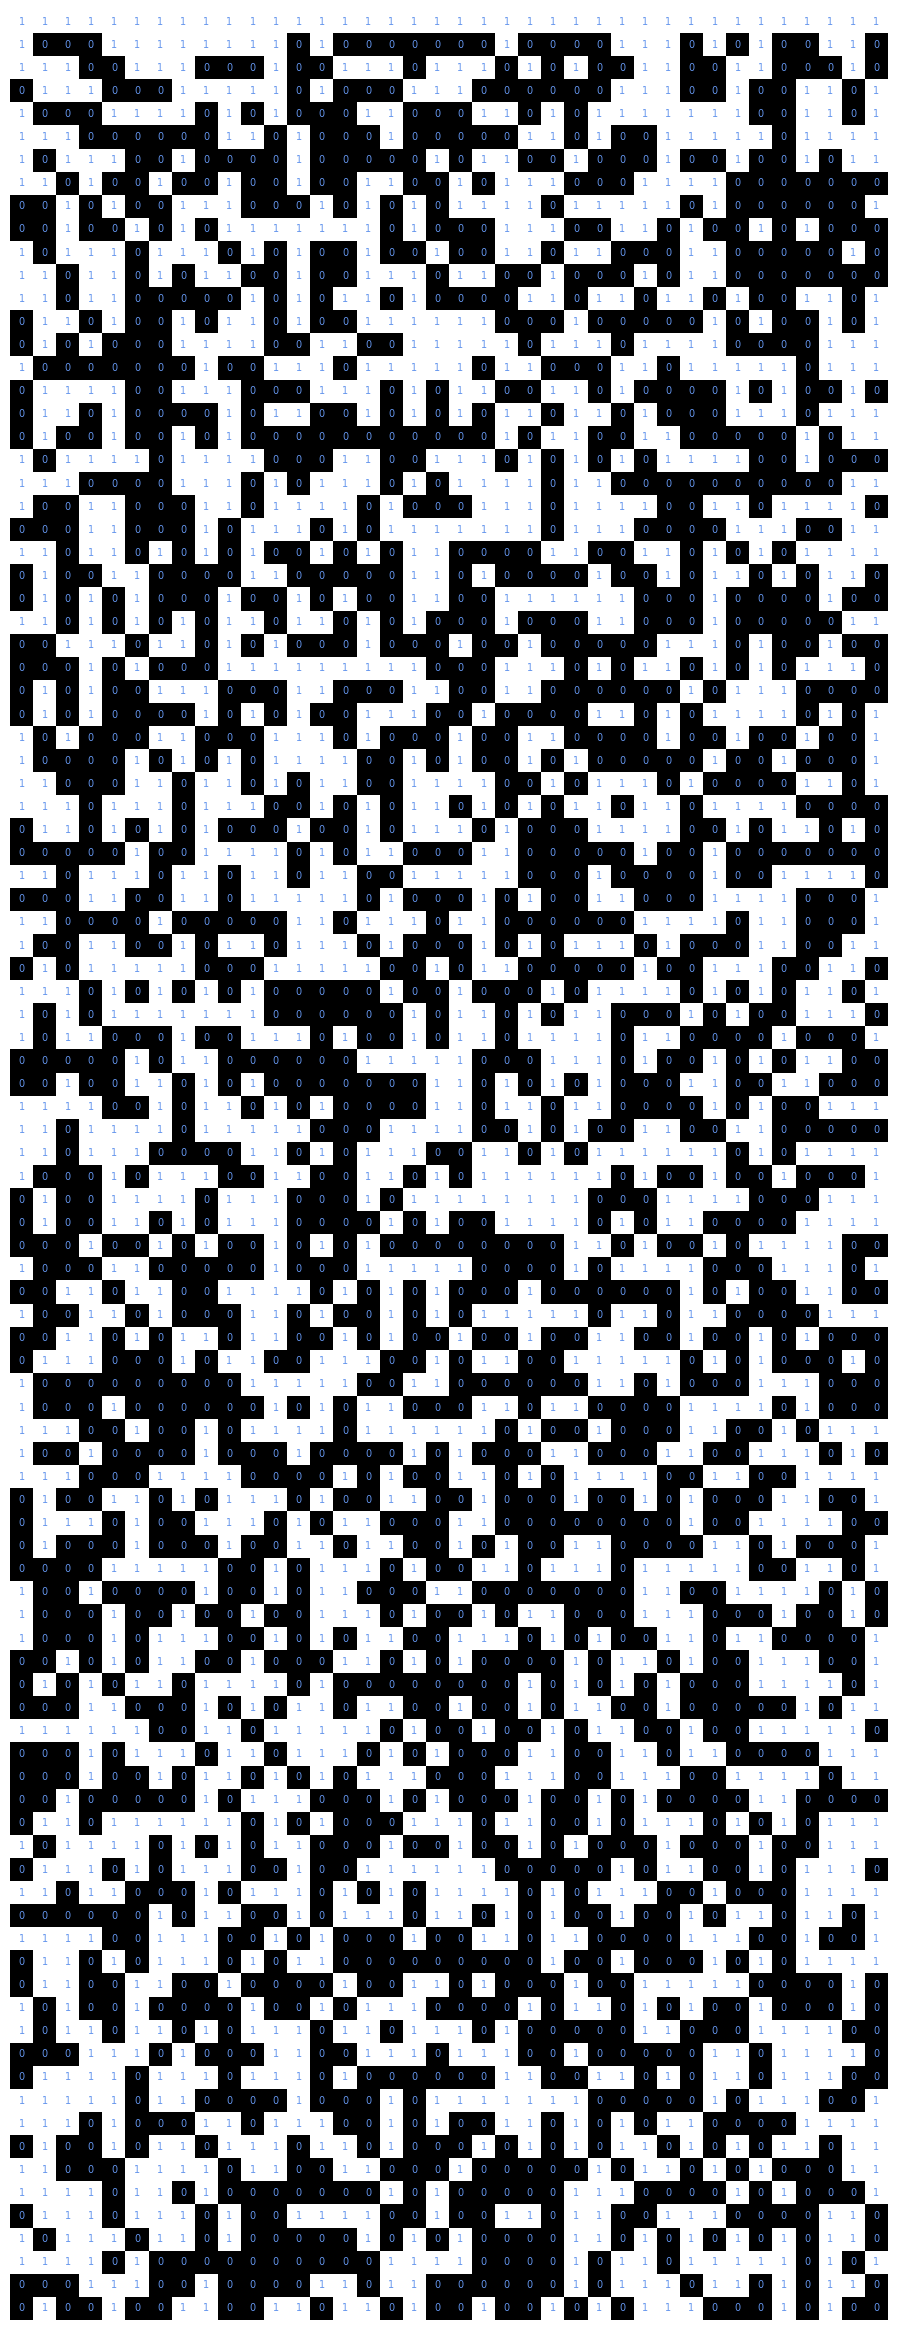

In [52]:
# Visialization of the input for the ridge regression.

fig, ax = plt.subplots(figsize=(30, 30))
ax.imshow(ridge_input_x[0], cmap='gray')

for i in range(ridge_input_x[0].shape[0]):
    for j in range(ridge_input_x[0].shape[1]):
        ax.text(j, i, ridge_input_x[0][i, j], color='cornflowerblue', ha='center', va='center', size=7)
plt.axis('off')

In [45]:
# Pandas DF for the input for the ridge regression.
ridge_input_x_df = pd.DataFrame(ridge_input_x[0])
ridge_input_x_df

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,...,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
1,0.2,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.2,0.2,...,0.2,0.0,0.2,0.0,0.2,0.0,0.0,0.2,0.2,0.0
2,0.2,0.2,0.2,0.0,0.0,0.2,0.2,0.2,0.0,0.0,...,0.2,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.2,0.0
3,0.0,0.2,0.2,0.2,0.0,0.0,0.0,0.2,0.2,0.2,...,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.2,0.0,0.2
4,0.2,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.0,0.2,...,0.2,0.2,0.2,0.2,0.0,0.0,0.2,0.2,0.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.2,0.2,0.2,0.0,0.2,0.2,0.2,0.0,0.2,...,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.2,0.2,0.0
96,0.2,0.0,0.2,0.2,0.2,0.0,0.2,0.2,0.0,0.2,...,0.0,0.2,0.0,0.2,0.0,0.2,0.0,0.2,0.2,0.0
97,0.2,0.2,0.2,0.2,0.0,0.2,0.0,0.0,0.0,0.0,...,0.0,0.2,0.2,0.2,0.2,0.2,0.0,0.2,0.0,0.2
98,0.0,0.0,0.0,0.2,0.2,0.2,0.0,0.0,0.2,0.0,...,0.2,0.0,0.2,0.2,0.0,0.2,0.0,0.2,0.2,0.0


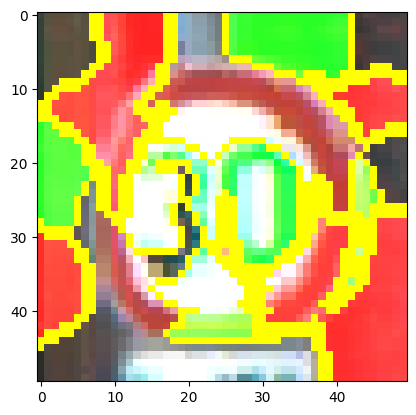

In [57]:
#Prediction for "30km"
#The number of superpixels is 20.

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

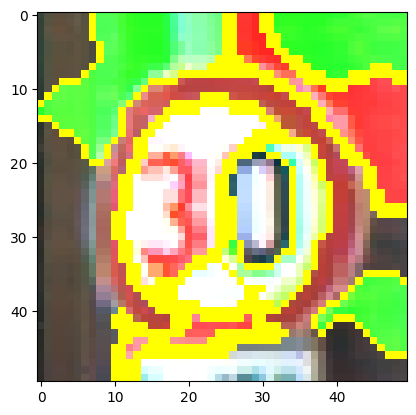

In [58]:
#Prediction for "80km"
# #The number of superpixels is 30.

temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [32]:
# SHAP

1/1 [==============================] - 0s 12ms/step


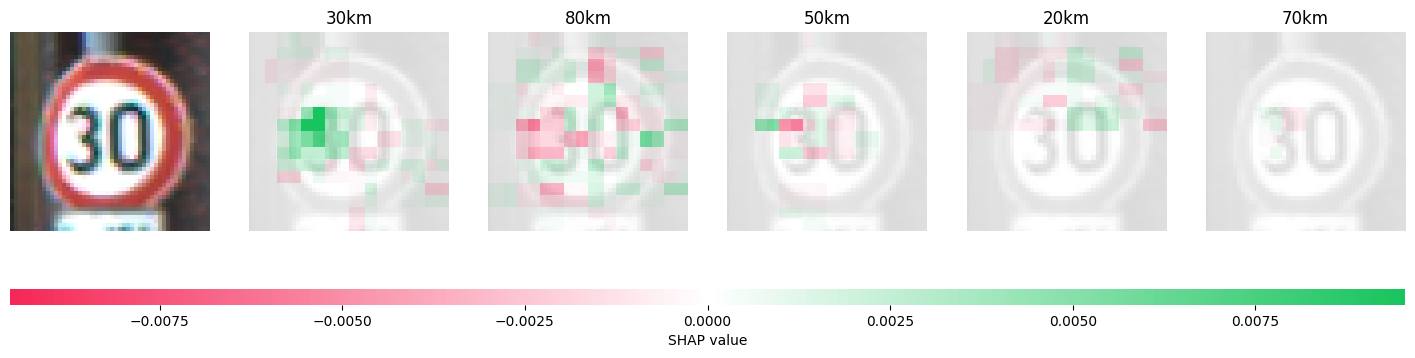

In [84]:
# based on example: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/image.html
# use class names as a vectorized mapping function from ids to names
class_names = list(my_information.values())

# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", X_test[0].shape)

# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(model, masker, output_names=class_names)
colors = []
for l in np.linspace(1,0,100):
	colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
	colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)
# here we use 2000 evaluations of the underlying model to estimate the SHAP values
ind = (-model.predict(X_test[i].reshape(1,50,50,3))[0]).argsort()
shap_values = explainer(X_test[i:i+1]*255, max_evals=2000, batch_size=500, outputs=ind[:5])
shap.image_plot(shap_values, pixel_values=X_test[i:i+1], cmap=cm,show=False)
    #plt.savefig("shap_{}.png".format(i))

In [75]:
def load_image(filename):
	img = load_img(filename, target_size=(50, 50))
	img = img_to_array(img)
	img = img.reshape(1, 50, 50, 3)
	img = img.astype('float32')
	return img

file = "...Test/00001.png"
img = load_image(file)
e = shap.GradientExplainer(model, X_test/255, session=None, batch_size=500, local_smoothing=0)
shap_values = e.shap_values(img/255)

/opt/homebrew/lib/python3.11/site-packages/keras/src/backend.py:452: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.



1/1 [==============================] - 0s 11ms/step


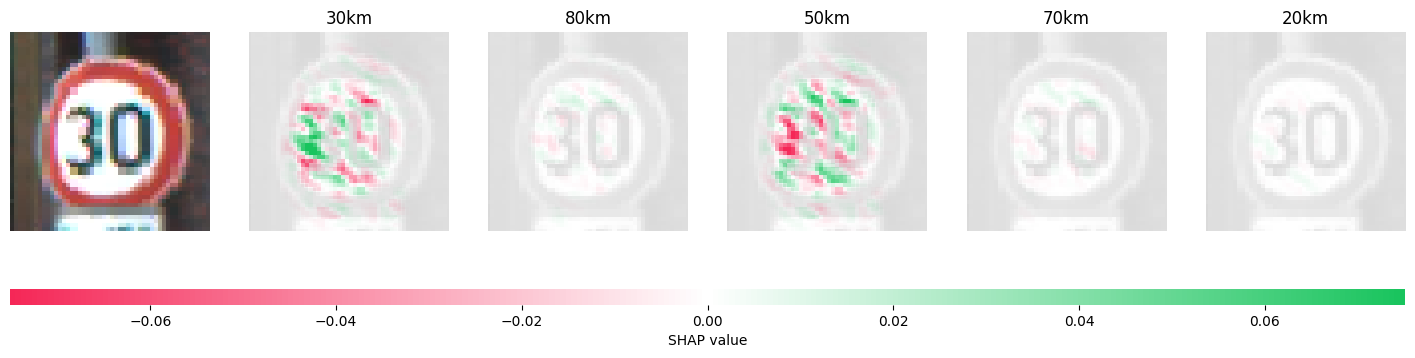

In [76]:
# plot the feature attributions
# make a color map
colors = []
for l in np.linspace(1,0,100):
	colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
	colors.append((24/255,196/255,93/255,l))
	
cm = LinearSegmentedColormap.from_list("shap", colors)

shaps = []
for i in range(0,43):
    shaps.append([np.sum(shap_values[i]), shap_values[i]])
shaps.sort(key=lambda x: x[0], reverse=True)

shap_values_updated = []
for s in shaps:
    shap_values_updated.append(s[1])

ind = (-model.predict(img.reshape(1,50,50,3)/255)[0]).argsort()
order = []
for i in range(0,43):
    order.append(list(my_information.values())[(ind)[i]])
shap.image_plot(shap_values_updated[0:5], img/255, labels=order, show=True, width=20, hspace=0.2, labelpad=None, cmap=cm)

In [78]:
def mask_image(zs, segmentation, image, background=None):
    
    if background is None:
        background = image.mean((0, 1))
        
    # Create an empty 4D array
    out = np.zeros((zs.shape[0], 
                    image.shape[0], 
                    image.shape[1], 
                    image.shape[2]))
    
    for i in range(zs.shape[0]):
        out[i, :, :, :] = image
        for j in range(zs.shape[1]):
            if zs[i, j] == 0:
                out[i][segmentation == j, :] = background
    return out
    
def f(z):
    return model.predict(
        preprocess_input(mask_image(z, segmentation_fn, img_orig, 255)))

img = image
explainer = shap.KernelExplainer(f, np.zeros((1,200)))

1/1 [==============================] - 0s 12ms/step


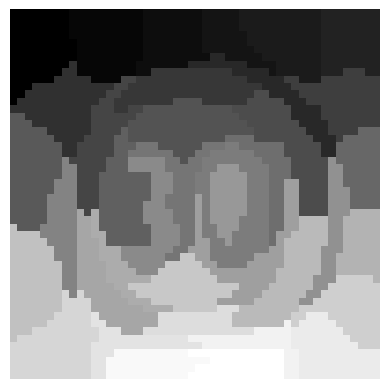

In [86]:
img=img_orig
segmentation_fn = SegmentationAlgorithm("slic", n_segments=30, compactness=15, sigma=1)
label=segmentation_fn(img)

def mean_image(image,label):
    im_rp=image.reshape((image.shape[0]*image.shape[1],image.shape[2]))
    sli_1d=np.reshape(label,-1)    
    uni=np.unique(sli_1d)
    uu=np.zeros(im_rp.shape)
    for i in uni:
        loc=np.where(sli_1d==i)[0]
        #print(loc)
        mm=np.mean(im_rp[loc,:],axis=0)
        uu[loc,:]=mm
    oo=np.reshape(uu,[image.shape[0],image.shape[1],image.shape[2]])
    return oo
    cv.imshow('img',oo)
output=mean_image(img,label) # displays the output image.
plt.imshow(output)
# %time
# Colorless segmentation framework
segments_slic = slic(img, n_segments=30, compactness=15, sigma=1)
plt.imshow(segments_slic, cmap="gray")
plt.axis('off');

In [80]:
def mask_image(zs, segmentation, image, background=None):
    
    if background is None:
        background = image.mean((0, 1))
        
    # Create an empty 4D array
    out = np.zeros((zs.shape[0], 
                    image.shape[0], 
                    image.shape[1], 
                    image.shape[2]))
    
    for i in range(zs.shape[0]):
        out[i, :, :, :] = image
        for j in range(zs.shape[1]):
            if zs[i, j] == 0:
                out[i][segmentation == j, :] = background
    return out
    
def f(z):
    return model.predict(
        preprocess_input(mask_image(z, segments_slic, img_orig, 255)))
img = image
explainer = shap.KernelExplainer(f, np.zeros((1,200)))

1/1 [==============================] - 0s 13ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 1s 18ms/step


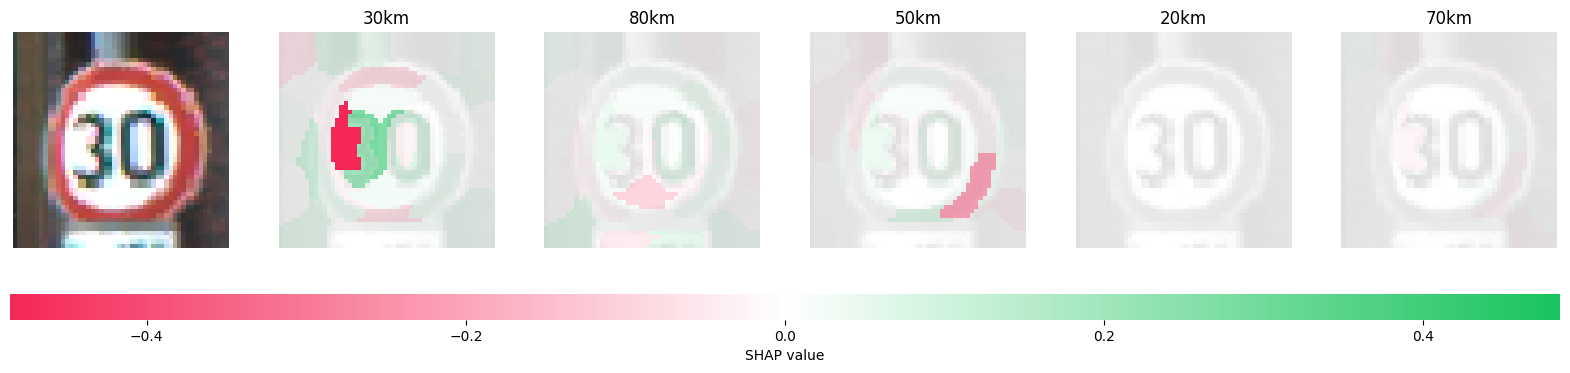

In [81]:
with warnings.catch_warnings():
	warnings.simplefilter("ignore")
	shap_values = explainer.shap_values(np.ones((1,200)), nsamples=2000) # runs the model 2000 times

# make a color map
colors = []
for l in np.linspace(1,0,100):
	colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
	colors.append((24/255,196/255,93/255,l))
	
cm = LinearSegmentedColormap.from_list("shap", colors)
# Visualize the explanations
def fill_segmentation(values, segmentation):
	out = np.zeros(segmentation.shape)
	for i in range(len(values)):
		out[segmentation == i] = values[i]
	return out
# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,4))
top_5_pred = top_5_pred.reset_index()
top_5_pred = top_5_pred.drop("index", axis=1)
inds = top_preds[0]
axes[0].imshow(img_orig)
axes[0].axis('off')
img_grey = load_img('...Test/00001.png', target_size=(50, 50))
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(5):
	m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
	axes[i+1].set_title(top_5_pred["feature_names"].iloc[i])
	axes[i+1].imshow(img_grey.convert('LA'), alpha=0.15)
	im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
	axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()
